In [1]:
# -*- coding: utf-8 -*-
import matplotlib as mpl
import math as math
import pandas as pd
import numpy as np
import scipy.stats as spstats
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# import IPython.core.display as di
# di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# 2018.3.1 k-nearest、linear classifier Notebook 
李曦嵘　　634602068@qq.com　　武汉大学电子信息学院


## 1、K临近分类

[CS231n课程笔记翻译：图像分类笔记（上）](https://zhuanlan.zhihu.com/p/20894041?refer=intelligentunit)

---

困难和挑战：对于人来说，识别出一个像“猫”一样视觉概念是简单至极的，然而从计算机视觉算法的角度来看就值得深思了。我们在下面列举了计算机视觉算法在图像识别方面遇到的一些困难，要记住图像是以3维数组来表示的，数组中的元素是亮度值。

- 视角变化（Viewpoint variation）：同一个物体，摄像机可以从多个角度来展现。
- 大小变化（Scale variation）：物体可视的大小通常是会变化的（不仅是在图片中，在真实世界中大小也是变化的）。
- 形变（Deformation）：很多东西的形状并非一成不变，会有很大变化。
- 遮挡（Occlusion）：目标物体可能被挡住。有时候只有物体的一小部分（可以小到几个像素）是可见的。
- 光照条件（Illumination conditions）：在像素层面上，光照的影响非常大。
- 背景干扰（Background clutter）：物体可能混入背景之中，使之难以被辨认。
- 类内差异（Intra-class variation）：一类物体的个体之间的外形差异很大，比如椅子。这一类物体有许多不同的对象，每个都有自己的外形。

面对以上所有变化及其组合，好的图像分类模型能够在维持分类结论稳定的同时，保持对类间差异足够敏感。

---

图像分类流程。在课程视频中已经学习过，图像分类就是输入一个元素为像素值的数组，然后给它分配一个分类标签。完整流程如下：

- 输入：输入是包含N个图像的集合，每个图像的标签是K种分类标签中的一种。这个集合称为训练集。
- 学习：这一步的任务是使用训练集来学习每个类到底长什么样。一般该步骤叫做训练分类器或者学习一个模型。
- 评价：让分类器来预测它未曾见过的图像的分类标签，并以此来评价分类器的质量。我们会把分类器预测的标签和图像真正的分类标签对比。

毫无疑问，分类器预测的分类标签和图像真正的分类标签如果一致，那就是好事，这样的情况越多越好。

### Nearest Neighbor分类器
作为课程介绍的第一个方法，我们来实现一个**Nearest Neighbor分类器**。虽然这个分类器和卷积神经网络没有任何关系，实际中也极少使用，但通过实现它，可以让读者对于解决图像分类问题的方法有个基本的认识。

**图像分类数据集：CIFAR-10**。一个非常流行的图像分类数据集是[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html)。这个数据集包含了60000张32X32的小图像。每张图像都有10种分类标签中的一种。这60000张图像被分为包含50000张图像的训练集和包含10000张图像的测试集。在下图中你可以看见10个类的10张随机图片。
![](https://pic4.zhimg.com/80/fff49fd8cec00f77f657a4c4a679b030_hd.jpg)
**左边**：从[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html)数据库来的样本图像。**右边**：第一列是测试图像，然后第一列的每个测试图像右边是使用Nearest Neighbor算法，根据像素差异，从训练集中选出的10张最类似的图片。

假设现在我们有CIFAR-10的50000张图片（每种分类5000张）作为训练集，我们希望将余下的10000作为测试集并给他们打上标签。Nearest Neighbor算法将会拿着测试图片和训练集中每一张图片去比较，然后将它认为最相似的那个训练集图片的标签赋给这张测试图片。上面右边的图片就展示了这样的结果。请注意上面10个分类中，只有3个是准确的。比如第8行中，马头被分类为一个红色的跑车，原因在于红色跑车的黑色背景非常强烈，所以这匹马就被错误分类为跑车了。

那么具体如何比较两张图片呢？在本例中，就是比较32x32x3的像素块。最简单的方法就是逐个像素比较，最后将差异值全部加起来。换句话说，就是将两张图片先转化为两个向量$I_1$和$I_2$，然后计算他们的L1距离：

$$
\displaystyle d_1(I_1,I_2)=\sum_p|I^p_1-I^p_2|
$$

这里的求和是针对所有的像素。下面是整个比较流程的图例：

![](https://pic1.zhimg.com/80/95cfe7d9efb83806299c218e0710a6c5_hd.jpg)

以图片中的一个颜色通道为例来进行说明。两张图片使用L1距离来进行比较。逐个像素求差值，然后将所有差值加起来得到一个数值。如果两张图片一模一样，那么L1距离为0，但是如果两张图片很是不同，那L1值将会非常大。

---

**距离选择**：计算向量间的距离有很多种方法，另一个常用的方法是L2距离，从几何学的角度，可以理解为它在计算两个向量间的欧式距离。L2距离的公式如下：

$$
\displaystyle d_2(I_1,I_2)=\sqrt{ \sum_p(I^p_1-I^p_2)^2}
$$

换句话说，我们依旧是在计算像素间的差值，只是先求其平方，然后把这些平方全部加起来，最后对这个和开方。在Numpy中，我们只需要替换上面代码中的1行代码就行。


## 2、支持向量机
[斯坦福CS231n项目实战（二）：线性支持向量机SVM](https://zhuanlan.zhihu.com/p/33627492)

支持向量机(Support Vector Machine, SVM)的目标是希望正确类别样本的分数( $W^TX$ )比错误类别的分数越大越好。两者之间的最小距离(margin)我们用 $\Delta$ 来表示，一般令 $\Delta =1$。

对于单个样本，SVM的Loss function可表示为：

$$
L_i=\sum_{j\neq y_i}max(0,s_j-s_{y_i}+\Delta)
$$

将 $s_j=W_j^Tx_i ， s_{y_i}=W_{y_i}^Tx_i$ 带入上式：

$$
L_i=\sum_{j\neq y_i}max(0,W_j^Tx_i-W_{y_i}^Tx_i+\Delta)
$$

其中， $(x_i,y_i)$ 表示正确类别，$ s_{y_i}$ 表示正确类别的分数score， $s_j $表示错误类别的分数score。从 $L_i$ 表达式来看， $s_j$ 不仅要比 $s_{y_i}$ 小，而且距离至少是 $\Delta$ ，才能保证 $L_i=0$ 。若 $s_j>s_{y_i}+\Delta$ ，则 $L_i>0$ 。也就是说SVM希望 $s_j$ 与 $s_{y_i}$ 至少相差一个Δ的距离。

该Loss function我们称之为Hinge Loss:

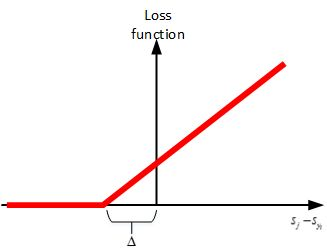![](https://pic1.zhimg.com/80/v2-84229fcc6610eb625dcb8ce6440ca65c_hd.jpg)

举个简单的例子，假如一个三分类的输出分数为：[10, 20, -10]，正确的类别是第0类，则该样本的Loss function为：


$$
L_i=max(0, 20-10+1)+max(0, -10-10+1)=11
$$


若正确的类别是第1类，则Loss function为：


$$
L_i=max(0, 10-20+1)+max(0, -10-20+1)=0
$$


值得一提的是，还可以对hinge loss进行平方处理，也称为L2-SVM。其Loss function为：


$$
L_i=\sum_{j\neq y_i}max(0,W_j^Tx_i-W_{y_i}^Tx_i+\Delta)^2
$$


这种平方处理的目的是增大对正类别与负类别之间距离的惩罚。

为了防止过拟合，限制权重Ｗ的大小，引入正则项：


$$
L_i=\sum_{j\neq y_i}max(0,W_j^Tx_i-W_{y_i}^Tx_i+\Delta)+\lambda \sum_k\sum_l W_{k,l}^2
$$

L2正则项作用是限制权重W过大，且使得权重W分布均匀。而L1正则项倾向于得到离散的W，各W之间差距较大。

## ML notebook - SVM

[知乎专栏：机器学习笔记-SVM](https://zhuanlan.zhihu.com/p/21678475)

### 1.3 The mathematics behind large margin classification

下面我们从数学角度看一下SVM。 

通过简化问题，我们知道要求的最小值为的最小值，即的范数最小值。 

![](http://img.blog.csdn.net/20170531181437743?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

下面看一下限制条件代表的含义，通过高中数学，我们知道两个向量相乘的几何含义如下:

![](http://img.blog.csdn.net/20170531181853170?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

通过上面可知，我们要求的最小值，因此我们希望尽量大。

假如选择了下面图中的绿色线作为边界，我们会发现比较小，这样不能得出的最小值。 

![](http://img.blog.csdn.net/20170531182401955?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

如果选择下面的绿色线作为边界，我们可以得到较小的值。

![](http://img.blog.csdn.net/20170531182604397?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

这样我们就从直观上感受了SVM作为大间距分类器的效果。

### 1.4 Kernels
之前的课程中我们讲解了使用多项式解决非线性拟合问题，在这里我们通过引入核函数来解决这个问题。 

![](http://img.blog.csdn.net/20170531193415366?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

假设函数给出几个向量作为landmarks：

![](http://img.blog.csdn.net/20170531194358386?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

引入高斯核函数：

$$
f_j=similarity(x,l^{(j)})=exp(\frac{-(x-l^{(j)})^2}{2\sigma ^2} )
$$

当x与l越接近，则函数值为1；当x与l越远，则函数值趋近0。

关于landmarks我们应该怎么选取呢？

我们可以把x个数据集作为landmarks。

![image.png](http://img.blog.csdn.net/20170531205625277?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

这样，对于每一个训练集中的数据，我们都有一个m+1维向量与之对应。 

![](http://img.blog.csdn.net/20170531210155191?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

在预测时：

![](http://img.blog.csdn.net/20170531210416991?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

关于参数对算法的影响 

大C:低偏差，高方差（对应低） 

小C:高偏差，低方差（对应高）

大：分布更平滑，高偏差，低方差 

小：分布更集中，低偏差，高方差 

**使用SVM步骤：**
![](http://img.blog.csdn.net/20170531211622040?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)

**SVM vs Logistic regression **
![](http://img.blog.csdn.net/20170531211739417?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMjcwMDgwNzk=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)